In [1]:
import serial
import time
import re
import pandas as pd
import numpy as np
import pickle
import json

from IPython.display import IFrame
import serial.tools.list_ports

import pickle
import numpy as np
from pyargus.directionEstimation import *

import math
from collections import deque
from scipy.spatial import distance

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings('ignore')

In /home/rabbi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rabbi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rabbi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rabbi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rabbi/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [12]:
class Localizer():
    
    
    def __init__(self):
        super(Localizer, self).__init__()
        
        self.baud_rate = 115200
        self.timeout = 1
        
        self.devices = []
        self.coords = []
        
        self.width = [-2,10]
        self.height = [-2,14]
        
        self.spacing = 0.1
        
        self.anchors = [
            {"anchor": "A",
            "coord": [0,0]},
            {"anchor": "B",
            "coord": [8,0]},
            {"anchor": "C",
            "coord": [8,12]},
            {"anchor": "A",
            "coord": [0,12]},
            ]

        #manufacturer given
        self.tag_id = {
            " 5817": "Tag 1",
            " 58AD": "Tag 2",
            " 123B": "Tag 3"
        }
        self.tag_color = {
            " 5817": "Green",
            " 58AD": "Blue",
            " 123B": "Black"
        }
        
    def connect_serial(self):
        port = self.get_port()
        self.uart = serial.Serial(port, baudrate=self.baud_rate, timeout = self.timeout)
    
    def disconnect_serial(self):
        self.uart.close()
        
    def get_port(self):
        ports = serial.tools.list_ports.comports()

        for port, desc, hwid in sorted(ports):

            if "J-Link" in desc:
                return port

        return null

    def get_serial_data(self):

        if self.uart.is_open:

            received_data = self.uart.inWaiting()
            if received_data:
                data = self.uart.read(received_data)
                data = data.decode('windows-1252')
                
                return data
            else:
                time.sleep(0.15)

        else:
            return("Uart not open")


    def compute_coordinates(self, data):
        df = re.split('\r|\n', data)
        df = pd.DataFrame(df, columns=['data'])
        df = df[[")" in x for x in df['data']]]

        self.coords = []
        
        for idx, row in df.iterrows():
            row = re.findall("[^()]+", row['data'])[1]
            row = re.split("\[(.*?)\]", row)

            id = row[0]

            row = re.split(',', row[1])

            coord = {
                "id": id,
                "x": float(row[0]),
                "y": float(row[1]),
                "z": float(row[2])
            }

            if not any(coord["id"]==d["id"] for d in self.coords): #don't add duplicates
                if not (np.isnan(coord['x']) or np.isnan(coord['y']) or np.isnan(coord['z'])): #don't add nans
                    self.coords.append(coord)

    def sanitize_coordinates(self):
        
        #initialize
        for coord in self.coords:
            if not any(coord["id"] == d["id"] for d in self.devices): #if coord[id] is not in device
                    self.devices.append(coord)
        
        #copy old coords from device if doesn't exist in current coords
        for device in self.devices:
            if not any(device["id"] == c["id"] for c in self.coords): # if device is not in coords
                self.coords.append(device)
        
        #update device
        self.devices = self.coords
        

    def visualize_tags(self):

        clear_output(wait=True)
        
        plt.figure(figsize=(12, 6)) 
        
        ax = plt.subplot(1,2,1)
        self.plot_anchors()

        for coord in self.coords:
            plt.plot(coord['x'], coord['y'], 'g^', markersize=8, 
                    mfc=self.tag_color[coord["id"]], mec = 'None',
                    label = self.tag_id[coord["id"]])
            
        #ax.legend(loc='center left', ncol=3, bbox_to_anchor=(0, -0.1))
        
        plt.xlim(self.width)
        plt.ylim(self.height)

    
    def visualize_prediction_box(self):

        ax = plt.subplot(1,2,2)
        
        x_range = np.arange(self.width[0], self.width[1], self.spacing)
        y_range = np.arange(self.height[0], self.height[1], self.spacing)
        
        for i in x_range:
            plt.axvline(x = i, color = 'b', linewidth=0.1)
        
        for i in y_range:
            plt.axhline(y = i, color = 'b', linewidth=0.1)
        
        
        for coord in self.coords:
        
            if np.isnan(coord['x']) or np.isnan(coord['y']):
                continue
        
            rect_x = self.search_insert_position(x_range, coord['x'])
            rect_y = self.search_insert_position(y_range, coord['y'])

            rect = Rectangle((x_range[rect_x], y_range[rect_y]),
                                self.spacing, self.spacing,
                                color = self.tag_color[coord["id"]],
                                label=self.tag_id[coord["id"]])

            ax.add_patch(rect)
        
        #ax.legend(loc='center left', ncol=3, bbox_to_anchor=(0, -0.1))
        
        plt.xlim(self.width)
        plt.ylim(self.height)
        plt.show()
    
    def plot_anchors(self):
        x= [a['coord'][0] for a in self.anchors]
        y = [a['coord'][1] for a in self.anchors]
        
        plt.plot(x,y, marker="^", markersize=8, markerfacecolor="None", 
                 markeredgecolor = "red", linestyle = 'None', label = "Anchor")
        
    
    def search_insert_position(self, nums, target):
        left = 0
        right = len(nums) - 1
        
        while left <= right:
            mid = (left + right) // 2
            
            if nums[mid] == target:
                return mid
            elif target > nums[mid]:
                left = mid + 1
            else:
                right = mid - 1
        
        return right

## Visualize live data

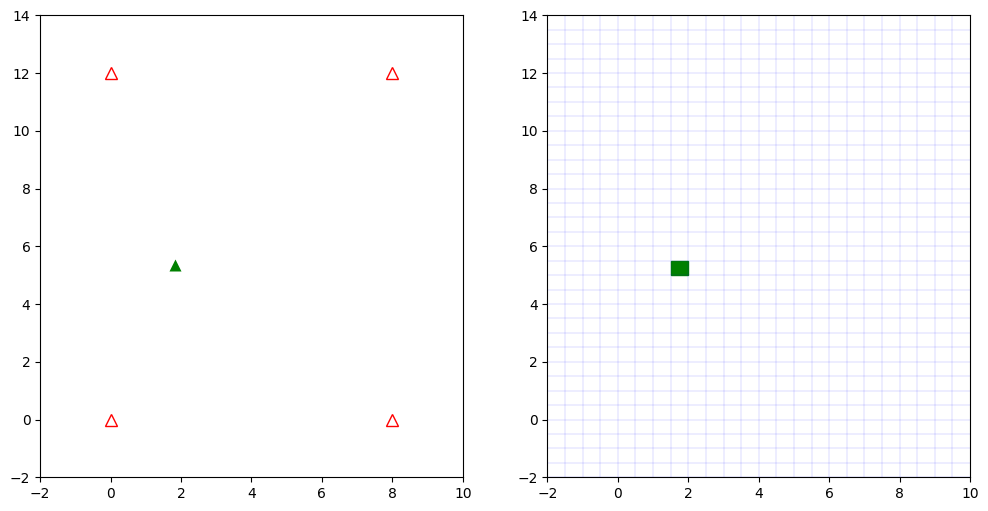

In [16]:
# localizer = Localizer()
# localizer.connect_serial()

# to_save = []

# localizer.spacing= 0.5
# for i in range(50):
#     try:
#         data = localizer.get_serial_data()
#         localizer.compute_coordinates(data)
#         localizer.sanitize_coordinates()
#         localizer.visualize_tags()
#         localizer.visualize_prediction_box()
#         to_save.append(localizer.coords)
#     except:
#         continue
        
# localizer.disconnect_serial()

# with open('data/saved_result_001', 'w') as fout:
#     json.dump(to_save, fout)

## Visualize saved data

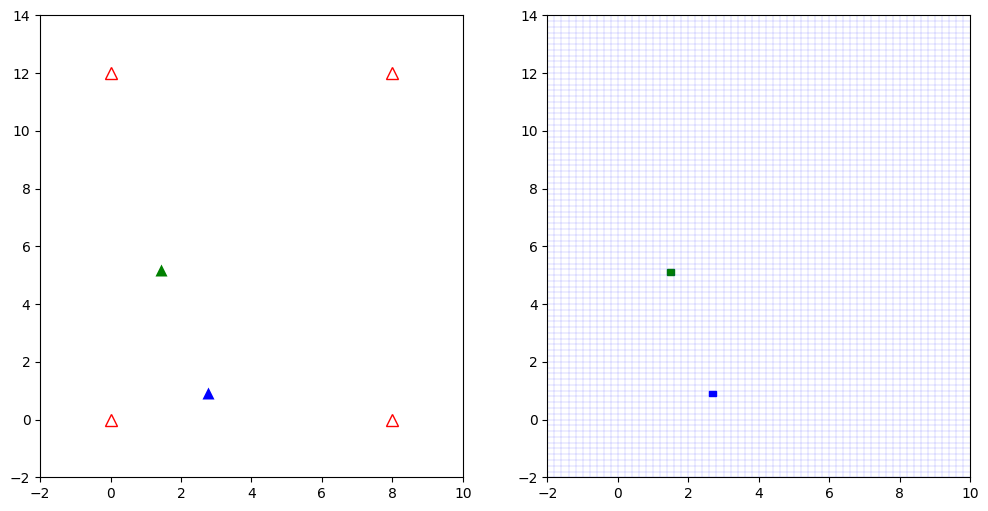

In [5]:
# flamingo = Flamingo()

# f = open('data/saved_result')
# data = json.load(f)

# itr = 0
# flamingo.spacing= 0.2
# for d in data:
    
#     flamingo.coords = d
#     flamingo.visualize_tags()
#     flamingo.visualize_prediction_box()
    
#     itr +=1
    
#     if(itr==500):
#         break